In [1]:
pip install torch torch-geometric networkx pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data


In [4]:
num_nodes = 50
num_edges = 150

# create nodes
# feautres: [inventory level (0-100), production capacity (0-100)]
node_ids = [f"Factory_{i}" for i in range (num_nodes)]
node_features = np.random.rand(num_nodes, 2) * 100
nodes_df = pd.DataFrame({
    'node_id': node_ids,
    'inventory': node_features[:, 0],
    'capacity': node_features[:, 1]
})

# create edges
# randomly connect factories
sources = np.random.choice(node_ids, num_edges)
targets = np.random.choice(node_ids, num_edges)

mask = sources != targets
sources = sources[mask]
targets = targets[mask]

edges_df = pd.DataFrame({
    'source': sources,
    'target': targets,
    'distance': np.random.randint(50, 100, size = len(sources))
})

print("--- Raw Data Generated ---")
print(f"Nodes: {len(nodes_df)}")
print(f"Edges: {len(edges_df)}")



--- Raw Data Generated ---
Nodes: 50
Edges: 148



--- PyTorch Geometric Graph Object ---
Data(x=[50, 2], edge_index=[2, 148], edge_attr=[148, 1])
Has isolated noes? False
Is directed? True


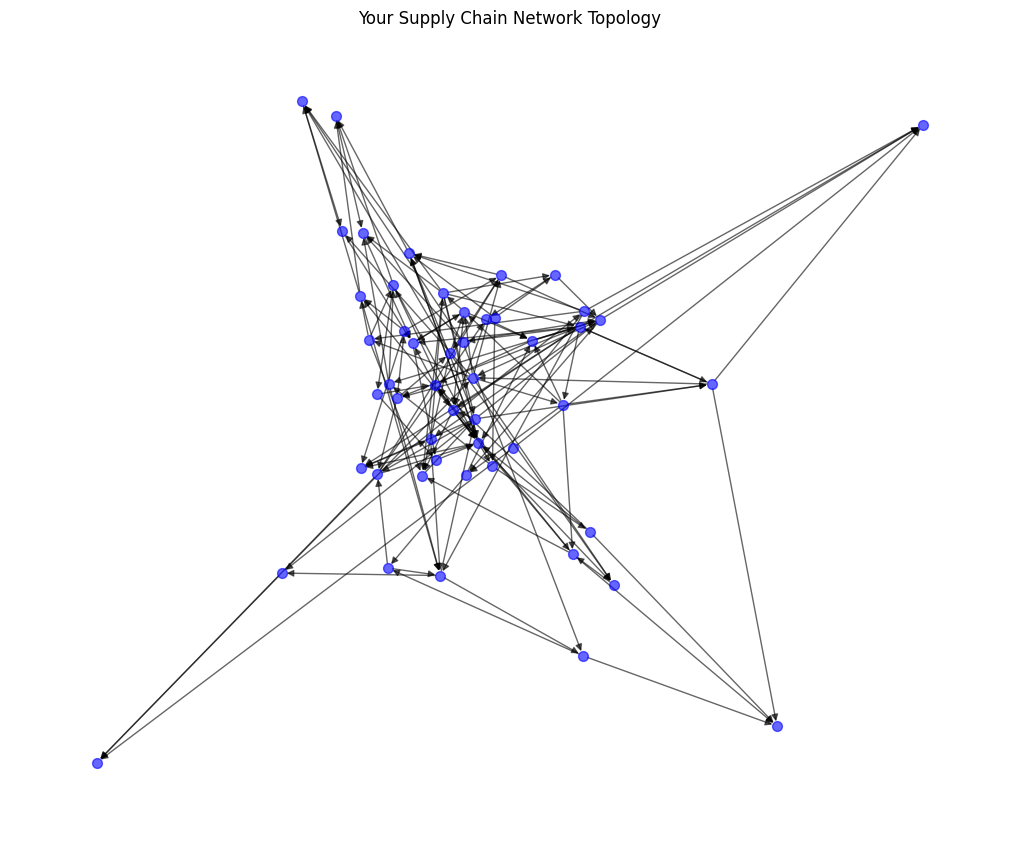

In [7]:
id_to_idx = {id: idx for idx, id in enumerate(nodes_df['node_id'])}

src_idx = [id_to_idx[s] for s in edges_df['source']]
dst_idx = [id_to_idx[t] for t in edges_df['target']]

edge_index = torch.tensor([src_idx, dst_idx], dtype = torch.long)

x = torch.tensor(nodes_df[['inventory', 'capacity']].values, dtype = torch.float)

edge_attr = torch.tensor(edges_df['distance'].values, dtype = torch.float).view(-1,1)

graph_data = Data(x = x, edge_index = edge_index, edge_attr = edge_attr)

print("\n--- PyTorch Geometric Graph Object ---")
print(graph_data)
print(f"Has isolated noes? {graph_data.has_isolated_nodes()}")
print(f"Is directed? {graph_data.is_directed()}")

from torch_geometric.utils import to_networkx
g_nx = to_networkx(graph_data, to_undirected = False)

plt.figure(figsize = (10, 8))
pos = nx.spring_layout(g_nx, seed = 42)
nx.draw(g_nx, pos, node_size = 50, node_color = 'blue', alpha = 0.6, with_labels = False)
plt.title("Your Supply Chain Network Topology")
plt.show()

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SupplyChainHydra(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        # ==========================================
        # 1. THE BODY (Shared Encoder)
        # ==========================================
        # Layer 1: Takes raw features (Inventory, Capacity) -> Hidden Space
        self.conv1 = SAGEConv(in_channels, hidden_channels)

        # Layer 2: Refines the knowledge by looking at neighbors again
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        # ==========================================
        # 2. HEAD 1: NODE REGRESSOR (Predict Delays)
        # ==========================================
        # Maps the complex embedding down to 1 single number (Minutes of Delay)
        self.regressor = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        # --- Step 1: Encode the Graph (The "Thinking" Phase) ---

        # Pass 1: Aggregates info from immediate neighbors
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)

        # Pass 2: Aggregates info from neighbors' neighbors (2 hops away)
        h = self.conv2(h, edge_index)

        # 'h' is now the Node Embedding (The "Context").
        # Shape: [Num_Nodes, Hidden_Channels]

        # --- Step 2: Activate Head 1 (Regression) ---
        delay_prediction = self.regressor(h)

        # --- Step 3: Output for Head 2 (Link Prediction) ---
        # For Link Prediction, we don't need a specific layer here.
        # We return the embeddings 'h' directly.
        # The logic is: If Dot_Product(h[A], h[B]) is high, they are linked.

        return delay_prediction, h

    # Helper function to actually predict a link probability between two nodes
    def decode_link(self, z, edge_label_index):
        # z: Node Embeddings (from forward pass)
        # edge_label_index: The specific pairs of nodes we want to check (Source, Target)

        # Get embeddings for source and target nodes
        src_emb = z[edge_label_index[0]]
        dst_emb = z[edge_label_index[1]]

        # Dot Product calculates similarity
        return (src_emb * dst_emb).sum(dim=-1)

# ==========================================
# INITIALIZE AND TEST
# ==========================================
# Input Features = 2 (Inventory, Capacity)
# Hidden Features = 16 (The size of the "brain")
model = SupplyChainHydra(in_channels=2, hidden_channels=16)

print("--- Model Architecture ---")
print(model)

# Run a Forward Pass with the data we created earlier
# Note: We don't train it yet, just checking if the plumbing works.
pred_delay, embeddings = model(graph_data.x, graph_data.edge_index)

print("\n--- Output Shapes ---")
print(f"Delay Predictions (Head 1): {pred_delay.shape}")  # Should be [50, 1]
print(f"Node Embeddings (Head 2):   {embeddings.shape}")  # Should be [50, 16]
print("\nSuccess! The Hydra is alive.")

--- Model Architecture ---
SupplyChainHydra(
  (conv1): SAGEConv(2, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (regressor): Linear(in_features=16, out_features=1, bias=True)
)

--- Output Shapes ---
Delay Predictions (Head 1): torch.Size([50, 1])
Node Embeddings (Head 2):   torch.Size([50, 16])

Success! The Hydra is alive.


In [9]:
import torch.optim as optim
from torch_geometric.utils import negative_sampling

# ==========================================
# 1. SETUP: PREPARE TARGETS & OPTIMIZER
# ==========================================

# A. Generate "Ground Truth" for Delays (Random values for this demo)
# In real life, this comes from your CSV (e.g., df['actual_delay'])
# Shape: [50, 1]
true_delays = torch.rand((50, 1)) * 10  # Random delays between 0 and 10 days
graph_data.y = true_delays

# B. The Optimizer (Adam is the standard choice)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# C. Loss Functions
criterion_reg = torch.nn.MSELoss()              # For Delay (Regression)
criterion_link = torch.nn.BCEWithLogitsLoss()   # For Connections (Classification)

print("Starting Training...")

# ==========================================
# 2. THE TRAINING LOOP
# ==========================================
for epoch in range(101):
    model.train()
    optimizer.zero_grad() # Clear old gradients

    # --- A. NEGATIVE SAMPLING (The "Fake" Edges) ---
    # We need to show the model edges that DO NOT exist so it learns the difference.
    # This creates a list of random edges that aren't in our graph.
    neg_edge_index = negative_sampling(
        edge_index=graph_data.edge_index,
        num_nodes=graph_data.num_nodes,
        num_neg_samples=graph_data.edge_index.size(1) # Same amount as real edges
    )

    # --- B. FORWARD PASS ---
    # Run the Hydra!
    pred_delay, embeddings = model(graph_data.x, graph_data.edge_index)

    # --- C. CALCULATE LOSS 1: LINK PREDICTION ---
    # 1. Score the REAL edges (Should be high)
    pos_score = model.decode_link(embeddings, graph_data.edge_index)
    # 2. Score the FAKE edges (Should be low)
    neg_score = model.decode_link(embeddings, neg_edge_index)
    # 3. Combine scores
    link_scores = torch.cat([pos_score, neg_score])
    link_labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])

    loss_link = criterion_link(link_scores, link_labels)

    # --- D. CALCULATE LOSS 2: REGRESSION (DELAYS) ---
    loss_reg = criterion_reg(pred_delay, graph_data.y)

    # --- E. COMPOSITE LOSS (Combine them) ---
    # We weight them equally (0.5 each)
    total_loss = loss_link + loss_reg

    # --- F. BACKPROPAGATION (Update Weights) ---
    total_loss.backward()
    optimizer.step()

    # --- G. MONITORING ---
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Total Loss: {total_loss.item():.4f} | Link Loss: {loss_link.item():.4f} | Reg Loss: {loss_reg.item():.4f}")

print("\nTraining Complete.")

Starting Training...
Epoch 000 | Total Loss: 3164.5222 | Link Loss: 2965.4729 | Reg Loss: 199.0493
Epoch 010 | Total Loss: 574.0208 | Link Loss: 551.6934 | Reg Loss: 22.3273
Epoch 020 | Total Loss: 205.8399 | Link Loss: 189.7248 | Reg Loss: 16.1151
Epoch 030 | Total Loss: 83.1558 | Link Loss: 63.7828 | Reg Loss: 19.3729
Epoch 040 | Total Loss: 52.1628 | Link Loss: 35.4932 | Reg Loss: 16.6696
Epoch 050 | Total Loss: 46.4061 | Link Loss: 33.1779 | Reg Loss: 13.2282
Epoch 060 | Total Loss: 42.1943 | Link Loss: 29.4336 | Reg Loss: 12.7607
Epoch 070 | Total Loss: 26.2569 | Link Loss: 12.5193 | Reg Loss: 13.7376
Epoch 080 | Total Loss: 23.2612 | Link Loss: 8.4806 | Reg Loss: 14.7806
Epoch 090 | Total Loss: 25.2651 | Link Loss: 14.4100 | Reg Loss: 10.8551
Epoch 100 | Total Loss: 24.0947 | Link Loss: 11.9927 | Reg Loss: 12.1020

Training Complete.


In [10]:
# ==========================================
# SCENARIO: STRIKE AT FACTORY 0
# ==========================================
target_node = 0  # The factory shutting down

# 1. BASELINE: How the world looks normally
model.eval() # Switch to evaluation mode
with torch.no_grad():
    base_delay, base_emb = model(graph_data.x, graph_data.edge_index)

# 2. THE DISRUPTION: Remove all connections to/from Target Node
# We create a mask to keep only edges that do NOT touch node 0
src, dst = graph_data.edge_index
mask = (src != target_node) & (dst != target_node)
broken_edge_index = graph_data.edge_index[:, mask]

print(f"Original Edges: {graph_data.edge_index.shape[1]}")
print(f"Edges after Strike: {broken_edge_index.shape[1]}")

# 3. NEW REALITY: Run the model on the broken graph
with torch.no_grad():
    new_delay, new_emb = model(graph_data.x, broken_edge_index)

# 4. MEASURE IMPACT
# Calculate the absolute change in predicted delay for every node
impact = torch.abs(new_delay - base_delay).flatten()

# 5. REPORTING
print(f"\n--- IMPACT REPORT: Strike at Node {target_node} ---")

# Find the top 5 most affected neighbors
# We sort by the magnitude of change
values, indices = torch.topk(impact, 6) # Top 6 (Node 0 will likely be #1, so we look at others)

for i in range(len(indices)):
    idx = indices[i].item()
    if idx == target_node:
        continue # Skip the node itself (obviously it changed)

    # Check if this node was a direct neighbor of the broken node
    is_neighbor = idx in graph_data.edge_index[1][graph_data.edge_index[0] == target_node]
    status = "DIRECT NEIGHBOR" if is_neighbor else "DOWNSTREAM NODE"

    print(f"Node {idx:02d} | Change in Risk: {values[i]:.4f} | Status: {status}")

Original Edges: 148
Edges after Strike: 133

--- IMPACT REPORT: Strike at Node 0 ---
Node 49 | Change in Risk: 2.0390 | Status: DOWNSTREAM NODE
Node 15 | Change in Risk: 1.0195 | Status: DOWNSTREAM NODE
Node 18 | Change in Risk: 0.9668 | Status: DIRECT NEIGHBOR
Node 40 | Change in Risk: 0.3771 | Status: DOWNSTREAM NODE
Node 45 | Change in Risk: 0.3300 | Status: DIRECT NEIGHBOR


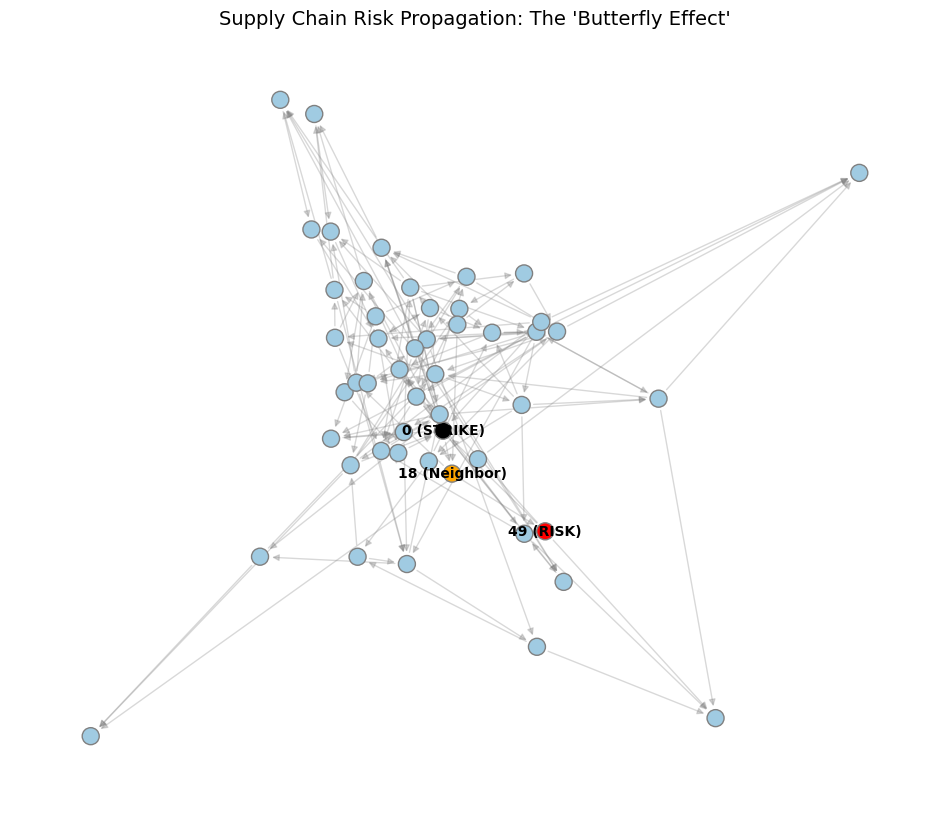

In [11]:
# ==========================================
# FINAL VISUALIZATION: THE IMPACT MAP
# ==========================================
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# 1. Ensure we have the NetworkX object
# (Re-running this just to be safe, in case the previous cell wasn't run)
g_nx = to_networkx(graph_data, to_undirected=False)

# 2. Define Color Logic
# Create a list of colors, one for every node in the graph
node_colors = []
for i in range(g_nx.number_of_nodes()):
    if i == 0:
        node_colors.append('black')    # The "Dead" Factory (Strike Location)
    elif i == 49:
        node_colors.append('red')      # The High-Risk Downstream Victim
    elif i == 18:
        node_colors.append('orange')   # The Affected Neighbor
    else:
        node_colors.append('#A0CBE2')  # Standard Blue for everyone else

# 3. Draw the Graph
plt.figure(figsize=(12, 10))

# Use a consistent layout (seed=42 fixes the positions)
pos = nx.spring_layout(g_nx, seed=42, k=0.15)

# Draw nodes with our custom color list
nx.draw_networkx_nodes(
    g_nx, pos,
    node_color=node_colors,
    node_size=150,
    edgecolors='grey' # Add a small border to make colors pop
)

# Draw edges subtly in the background
nx.draw_networkx_edges(
    g_nx, pos,
    alpha=0.3,
    edge_color='grey'
)

# Add labels to key nodes so we can see them
labels = {0: '0 (STRIKE)', 49: '49 (RISK)', 18: '18 (Neighbor)'}
nx.draw_networkx_labels(g_nx, pos, labels=labels, font_size=10, font_weight='bold')

plt.title("Supply Chain Risk Propagation: The 'Butterfly Effect'", fontsize=14)
plt.axis('off') # Turn off the axis grid
plt.show()